<a href="https://colab.research.google.com/github/zirrashaphan/Stock_Market_Predictive_Model_LSTM/blob/main/Stock_Market_Predictive_Model_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Mounting my Google Drive at /content/drive
drive.mount('/content/drive')

# Verifying that my drive has been mounted by listing the files in the drive
!ls /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'   Datasets  'SMASHINGLOGO _ ‎Logo Maker - Google Chrome 13_04_2021 2_00_25 PM.mp4'


In [ ]:

# Defining the stock ticker and time period
ticker = 'TSLA'  # Example: Apple Inc.
start_date = '2015-01-01'
end_date = '2024-10-31'

# Scraping TSLA stock historical data from yahoo finance
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Displaying the first few rows
print(stock_data.head())

# Saving the scraped data as a CSV file to my drive
file_path = f'/content/drive/My Drive/Datasets/{ticker}_stock_data.csv'
stock_data.to_csv(file_path)

print(f"Data saved to {file_path}")



[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                          TSLA       TSLA       TSLA       TSLA   
Date                                                                    
2015-01-02 00:00:00+00:00  14.620667  14.620667  14.883333  14.217333   
2015-01-05 00:00:00+00:00  14.006000  14.006000  14.433333  13.810667   
2015-01-06 00:00:00+00:00  14.085333  14.085333  14.280000  13.614000   
2015-01-07 00:00:00+00:00  14.063333  14.063333  14.318667  13.985333   
2015-01-08 00:00:00+00:00  14.041333  14.041333  14.253333  14.000667   

Price                           Open    Volume  
Ticker                          TSLA      TSLA  
Date                                            
2015-01-02 00:00:00+00:00  14.858000  71466000  
2015-01-05 00:00:00+00:00  14.303333  80527500  
2015-01-06 00:00:00+00:00  14.004000  93928500  
2015-01-07 00:00:00+00:00  14.223333  44526000  
2015-01-08 00:00:00+00:00  14.187333  51637500  
Data saved to /content/

In [ ]:
# Loading the TSLA data
data = pd.read_csv(file_path, header=None)

# Renaming the first column of the first row to 'Date' and setting it as the header
data.iloc[0, 0] = 'Date'
data.columns = data.iloc[0]  # Set the first row as the header
data = data[1:]  # Drop the original header row

# Removing the second and third rows (index 1 and 2 after the header adjustment)
data = data.drop(index=[1, 2])

# Converting 'Date' column to datetime and setting it as the index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Resetting columns to remove any lingering issues
data.columns.name = None

# Converting all columns to numeric, ignoring the index (which is 'Date'); for easier computation
data.iloc[:, :] = data.apply(pd.to_numeric, errors='coerce')

# Viewing the cleaned data
print(data.head())
# Checking the DataFrame to confirm changes
print(data.info())

                           Adj Close      Close       High        Low  \
Date                                                                    
2015-01-02 00:00:00+00:00  14.620667  14.620667  14.883333  14.217333   
2015-01-05 00:00:00+00:00     14.006     14.006  14.433333  13.810667   
2015-01-06 00:00:00+00:00  14.085333  14.085333      14.28     13.614   
2015-01-07 00:00:00+00:00  14.063333  14.063333  14.318667  13.985333   
2015-01-08 00:00:00+00:00  14.041333  14.041333  14.253333  14.000667   

                                Open    Volume  
Date                                            
2015-01-02 00:00:00+00:00     14.858  71466000  
2015-01-05 00:00:00+00:00  14.303333  80527500  
2015-01-06 00:00:00+00:00     14.004  93928500  
2015-01-07 00:00:00+00:00  14.223333  44526000  
2015-01-08 00:00:00+00:00  14.187333  51637500  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2015-01-02 00:00:00+00:00 to 2024-10-30 00:00:00+00:00
Data columns (total 6 c

In [ ]:
# Removing the redundant 'Close' column since our focus is on 'Adj Close'
data = data.drop(columns=['Close'])

# Converting 'Volume' to integer (optional, depending on data type)
data['Volume'] = data['Volume'].astype(int)

# # Normalizing the Date index to remove the time component
# data.index = data.index.normalize()

# # Converting index to only date
# data.index = data.index.date

In [ ]:
fd_file_path = f'/content/drive/My Drive/Datasets/formatted_{ticker}_stock_data.csv'
data.to_csv(fd_file_path)

In [ ]:
print(data['Adj Close'].unique())

[14.620667457580566 14.005999565124512 14.085332870483398 ...
 262.510009765625 259.5199890136719 257.54998779296875]


In [ ]:
# Converting 'Adj Close' to numeric, setting errors='coerce' to handle non-numeric values
data['Adj Close'] = pd.to_numeric(data['Adj Close'], errors='coerce')


**FEATURE** **ENGINEERING**

In [ ]:
# Calculating Moving Averages
data['SMA_10'] = data['Adj Close'].rolling(window=10).mean()
data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
data['SMA_200'] = data['Adj Close'].rolling(window=200).mean()

# Calculating Volatility (10-day rolling standard deviation of Close price)
data['Volatility'] = data['Adj Close'].rolling(window=10).std()

# Calculating Daily Returns
data['Returns'] = data['Adj Close'].pct_change()

# Displaying the formatted dataset
print(data[['Adj Close', 'SMA_10', 'SMA_50', 'SMA_200', 'Volatility', 'Returns']].head(15))

                           Adj Close     SMA_10  SMA_50  SMA_200  Volatility  \
Date                                                                           
2015-01-02 00:00:00+00:00  14.620667        NaN     NaN      NaN         NaN   
2015-01-05 00:00:00+00:00  14.006000        NaN     NaN      NaN         NaN   
2015-01-06 00:00:00+00:00  14.085333        NaN     NaN      NaN         NaN   
2015-01-07 00:00:00+00:00  14.063333        NaN     NaN      NaN         NaN   
2015-01-08 00:00:00+00:00  14.041333        NaN     NaN      NaN         NaN   
2015-01-09 00:00:00+00:00  13.777333        NaN     NaN      NaN         NaN   
2015-01-12 00:00:00+00:00  13.480667        NaN     NaN      NaN         NaN   
2015-01-13 00:00:00+00:00  13.616667        NaN     NaN      NaN         NaN   
2015-01-14 00:00:00+00:00  12.846000        NaN     NaN      NaN         NaN   
2015-01-15 00:00:00+00:00  12.791333  13.732867     NaN      NaN    0.571886   
2015-01-16 00:00:00+00:00  12.871333  13

In [ ]:
# Creating lagged features to capture and inform the model about trends
for lag in range(1, 6):  # Create lagged features for the past 5 days
    data[f'Lag_{lag}'] = data['Adj Close'].shift(lag)

In [ ]:
# Calculating RSI (14-day) to measure the speed and change of price movements
delta = data['Adj Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

**HANDLING MISSING VALUES**

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

# Droping rows with missing data
data.dropna(inplace=True)

# Verifying that there are no missing values remaining
print("Missing values after handling:\n", data.isnull().sum())

Missing values per column:
 Adj Close       0
High            0
Low             0
Open            0
Volume          0
SMA_10          9
SMA_50         49
SMA_200       199
Volatility      9
Returns         1
Lag_1           1
Lag_2           2
Lag_3           3
Lag_4           4
Lag_5           5
RSI            13
dtype: int64
Missing values after handling:
 Adj Close     0
High          0
Low           0
Open          0
Volume        0
SMA_10        0
SMA_50        0
SMA_200       0
Volatility    0
Returns       0
Lag_1         0
Lag_2         0
Lag_3         0
Lag_4         0
Lag_5         0
RSI           0
dtype: int64


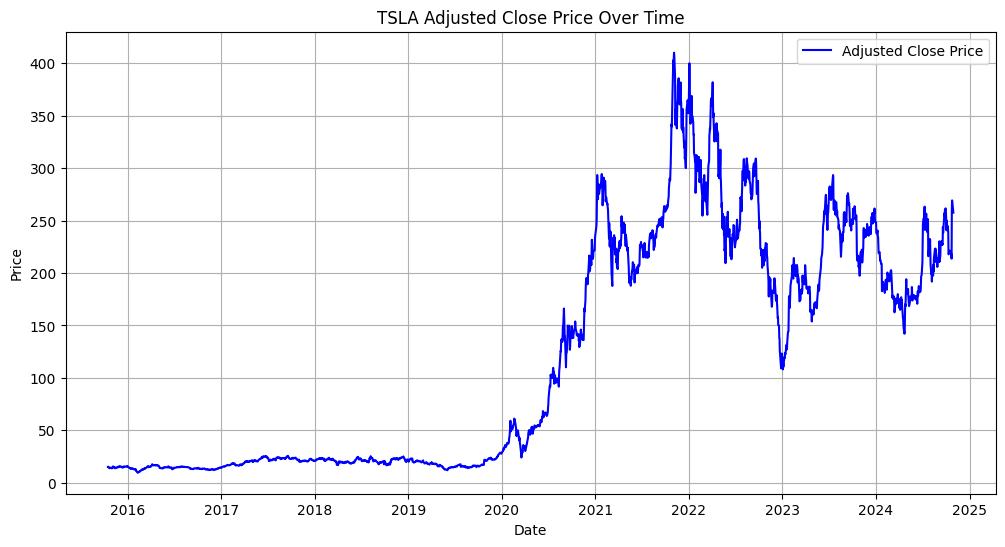

In [ ]:
# Visualising Tesla Stock Price Trend
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.title('TSLA Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

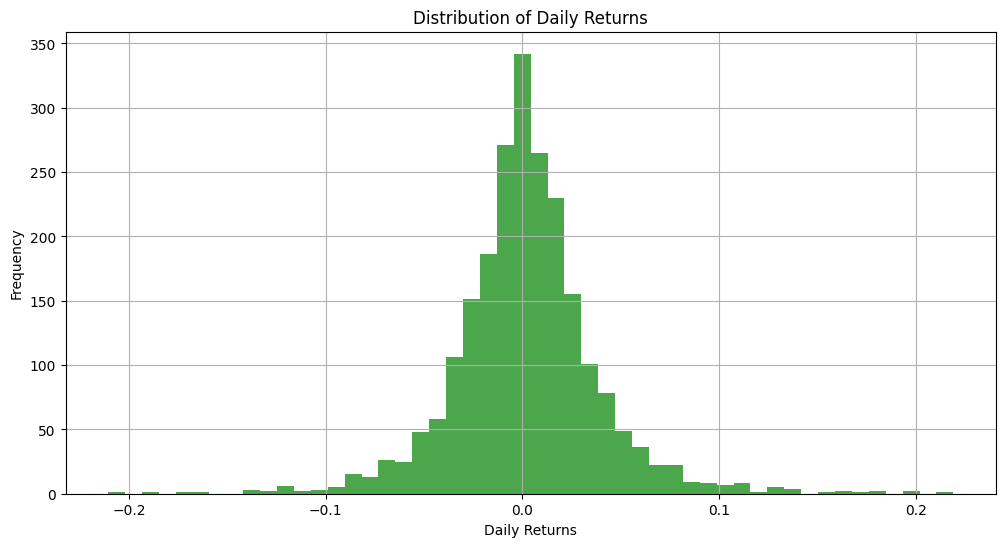

In [ ]:
# Checking Distribution of Returns
plt.figure(figsize=(12, 6))
plt.hist(data['Returns'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()

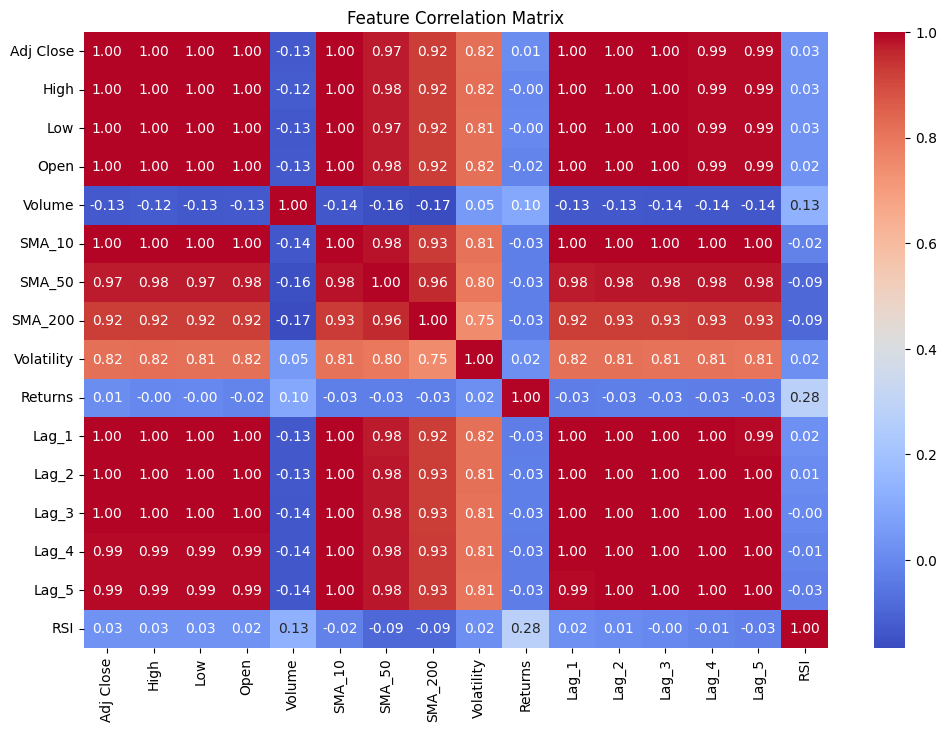

In [ ]:
# Using Heat Map and Correlation matrix to visualize correlations amongst features
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Visualizing Moving Averages

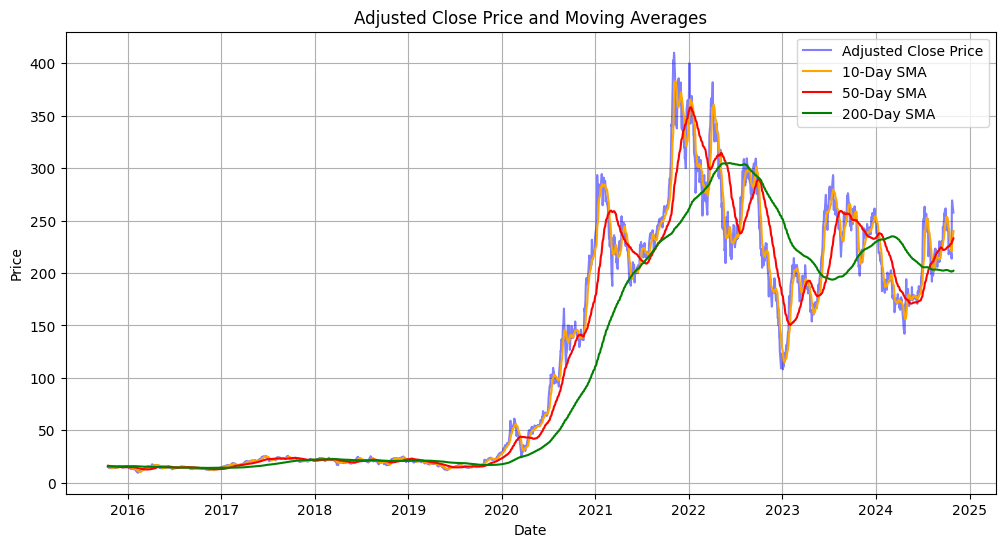

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price', color='blue', alpha=0.5)
plt.plot(data.index, data['SMA_10'], label='10-Day SMA', color='orange')
plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='red')
plt.plot(data.index, data['SMA_200'], label='200-Day SMA', color='green')
plt.title('Adjusted Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


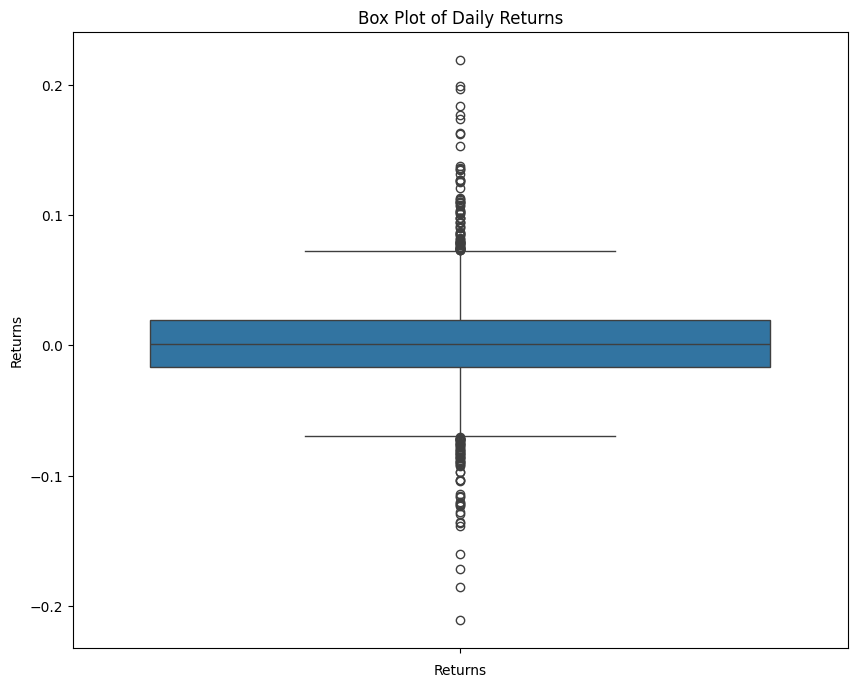

In [ ]:
#Plotting Box Plot to Detect Outliers

plt.figure(figsize=(10, 8))
sns.boxplot(data['Returns'])
plt.title('Box Plot of Daily Returns')
plt.xlabel('Returns')
plt.show()

In [ ]:
# Defining Split date to split data for training and testing
split_date = '2022-01-01'

# Creating the training set with data before the split date
train_data = data[data.index < split_date]

# Creating the testing set with data on or after the split date
test_data = data[data.index >= split_date]

# Defining features and target to be used for training
features = ['SMA_10', 'SMA_50', 'SMA_200', 'Volatility', 'Returns', 'RSI'] + [f'Lag_{lag}' for lag in range(1, 6)]
target = 'Adj Close'

# Removing rows with any NaN values in the feature columns
train_data = train_data.dropna(subset=features)
test_data = test_data.dropna(subset=features)

# Defining X and y for training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [ ]:
# Scaling the Data to make features be on similar scale
# Creating scalers for features and target
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling features and target variable
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled = feature_scaler.transform(X_test)  # Use the same scaler for test set
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))  # Use the same scaler for test set

In [ ]:
# Preparing the Data for LSTM
# Creating dataset with time steps
def create_lstm_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

# Defining time step
time_step = 5  # Using previous 5 days to predict the next day

#Partitioning the dataset
X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, y_train_scaled, time_step)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, y_test_scaled, time_step)


In [ ]:
# Defining the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

# Compiling the Model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Training the Model
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0257
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.5898e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4601e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3877e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2281e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7549e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3101e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1118e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5338e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1013e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6249e-04
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2146e-04
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5860e-04
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4350e-04
Epoch 15/50
49/49 ━━━━━━━━━━

In [ ]:
# Making Predictions
y_pred_scaled = model.predict(X_test_lstm)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Inverse transforming the predictions
y_pred = target_scaler.inverse_transform(y_pred_scaled)

# Inverse transforming the actual values
y_test_actual = target_scaler.inverse_transform(y_test_lstm)

# Checking the shapes of the actual and predicted arrays
print("Shape of Actual Prices:", y_test_actual.shape)
print("Shape of Predicted Prices:", y_pred.shape)


Shape of Actual Prices: (706, 1)
Shape of Predicted Prices: (706, 1)


In [ ]:
# Ensuring y_test_actual is flattened
y_test_actual = y_test_actual.flatten()

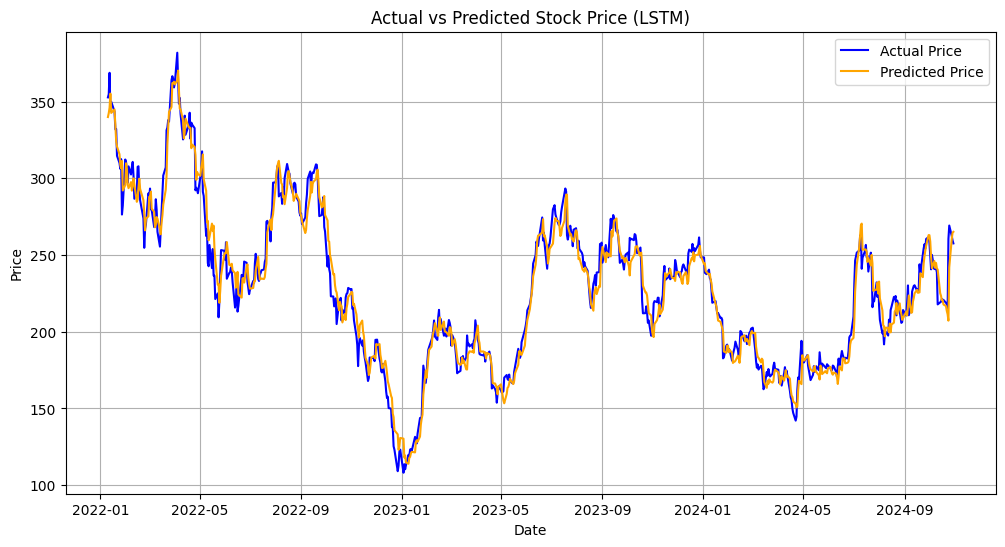

In [ ]:
# Plotting Actual Value Vs Predicted Value
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[-len(y_test_actual):], y_test_actual, label='Actual Price', color='blue')
plt.plot(test_data.index[-len(y_pred):], y_pred, label='Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Price (LSTM)')
plt.legend()
plt.grid()
plt.show()
